In [1]:
import pandas as pd
from pathlib import Path
import re
import subprocess
import numpy as np

import locations
from ipywidgets import widgets, Layout, fixed
import plotly.express as px

In [12]:
def all_tags():
    result = subprocess.run("git tag", cwd=locations.tokenized_kernel, capture_output=True, shell=True)
    return str(result.stdout, 'utf-8').strip().split("\n")

def tags():
    result = []
    for tag in all_tags():
        m = re.match(r'^v(\d+)\.(\d+)$', tag)
        if m:
            major, minor = m.groups()
            result.append((tag, int(major), int(minor)))
    return sorted(result, key=lambda x: x[1:3])

In [13]:
dfs = []

for tag,_,_ in tags():
    
    with open(locations.by_tag / tag / "coverage_by_directory.csv") as f:
        temp_df = pd.read_csv(f,
                              names=["directory",
                                     "non_static",
                                     "tested"]
                             ).fillna("")
        temp_df["tag"] = tag
        dfs.append(temp_df)
        
df = pd.concat(dfs)
df["ratio"] = df["tested"]/df["non_static"]

In [4]:
def make_plot(df, directory):
    directory=directory.rstrip("/")
    ax = df[df["directory"] == directory].plot(
        x="tag", y=["non_static", "tested", "ratio"], secondary_y="ratio", title=directory or 'whole kernel'
    )
    ax.set_xlabel("Version Number")
    ax.set_ylabel("Number of Functions")
    ax.right_ax.set_ylabel("Coverage Ratio")
    bottom, top = ax.get_ylim()
    ax.set_ylim(0, top)
    bottom, top = ax.right_ax.get_ylim()
    ax.right_ax.set_ylim(0, top)

/home/will-h/Documents/Courses/Honours/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


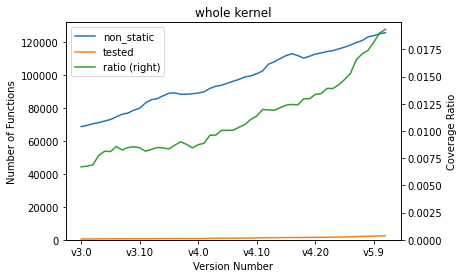

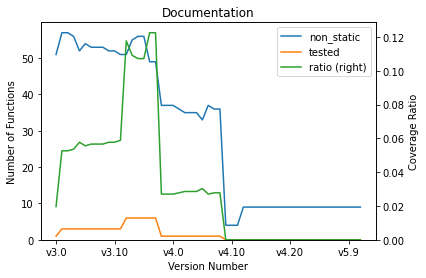

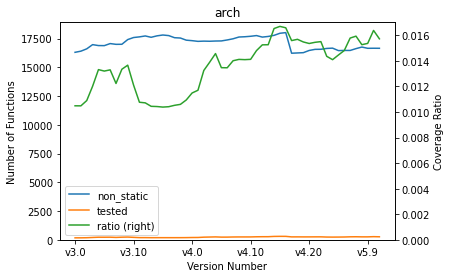

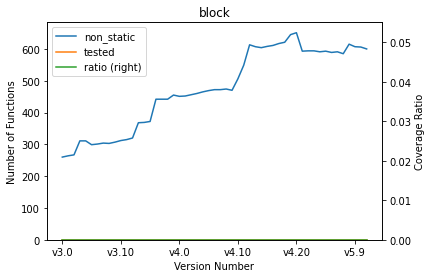

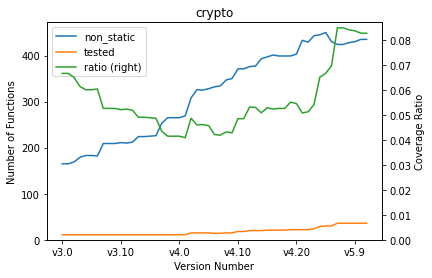

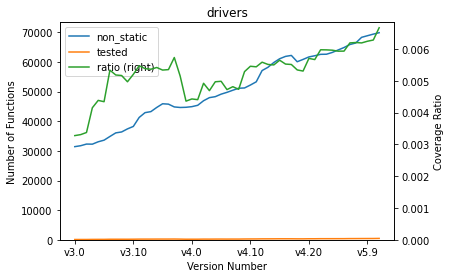

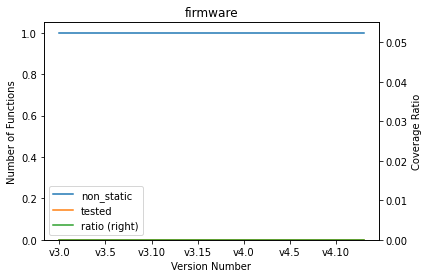

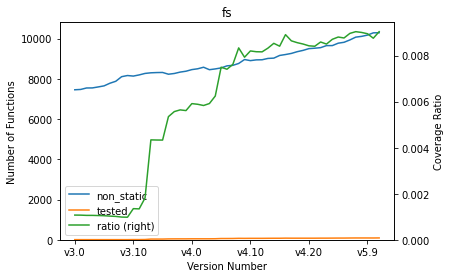

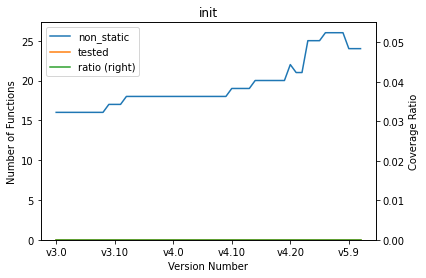

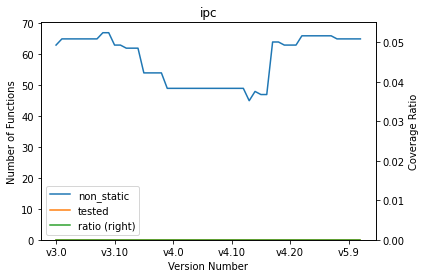

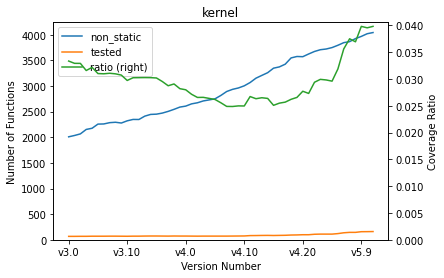

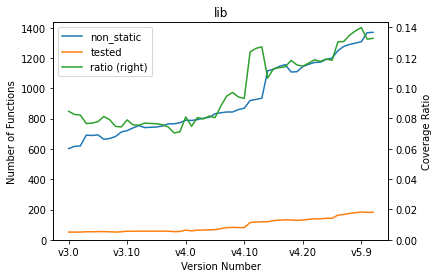

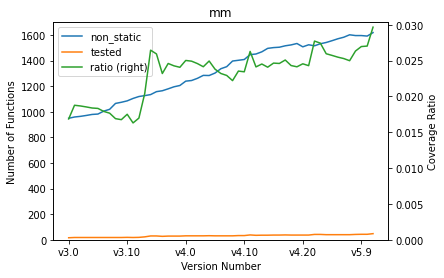

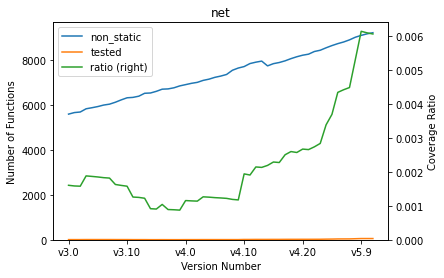

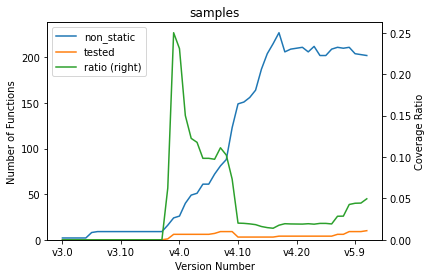

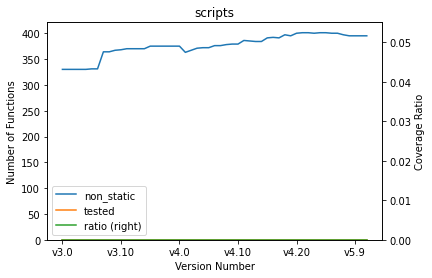

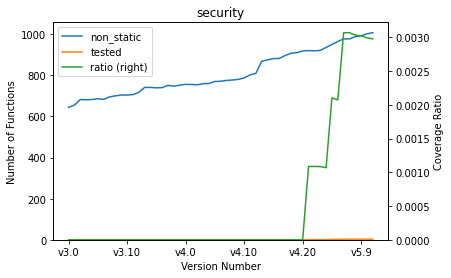

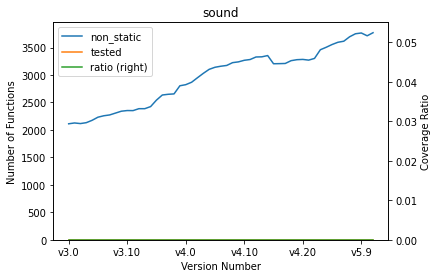

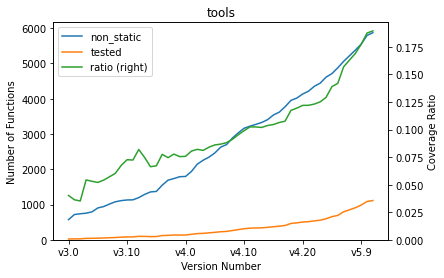

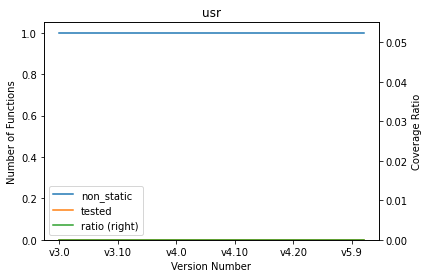

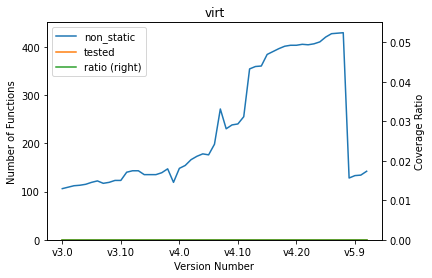

In [5]:
top_level = ['','Documentation','arch','block','crypto','drivers','firmware','fs',
'init','ipc','kernel','lib','mm','net','samples','scripts','security','sound','tools','usr','virt']


for directory in top_level:
    make_plot(df, directory)

In [6]:
def interactive_plot(df):
    selector = widgets.Combobox(options=list(set(df["directory"])), description="directory",
                        layout=Layout(width="500px"))
    plot = widgets.interactive_output(make_plot, {'df': fixed(df), 'directory':selector})
    display(plot, selector)

In [7]:
interactive_plot(df)

Output()

Combobox(value='', description='directory', layout=Layout(width='500px'), options=('', 'drivers/staging/hv/too…

In [8]:
nonzero_filter = df.groupby("directory").sum()["tested"] > 0
nonzero_test_dirs = list(nonzero_filter[nonzero_filter].index)
nonzero_tests = df[df["directory"].apply(lambda d: d in nonzero_test_dirs)]

In [9]:
interactive_plot(nonzero_tests)

Output()

Combobox(value='', description='directory', layout=Layout(width='500px'), options=('', 'lib/math', 'arch/x86/m…

In [19]:
def prep_treedf(df, version):
    treedf = df.copy()
    treedf = treedf[treedf.tag == version]
    treedf["directory"].replace("", "kernel root", inplace=True)

    treedf["parent"] = treedf["directory"].apply(get_parent)
    treedf["count excluding subdirectories"] = treedf["non_static"]

    rows = treedf.copy().iterrows()
    for parent,value in treedf.groupby("parent")["non_static"].sum().iteritems():
        treedf.loc[treedf["directory"] == parent,["count excluding subdirectories"]] -= value

    assert len(treedf[treedf["count excluding subdirectories"] < 0]) == 0
    return treedf

def treemap(df, version, log_color=False):
    treedf = prep_treedf(df, version)
    if log_color:
        color = np.log(treedf["ratio"],)
    else:
        color = "ratio"
    with np.errstate(divide='ignore'): # log(0) is undefined, ignore warnings from this
        fig = px.treemap(treedf, names="directory", parents="parent",
                         values="count excluding subdirectories", color=color,
                         color_continuous_scale=["red", "yellow", "green"],
                         height=600,
                         hover_data=["ratio", "non_static"]
                        )
    fig.show()
    
def get_parent(p):
    if p == "kernel root":
        return ""
    if "/" not in p:
        return "kernel root"
    return "/".join(p.split("/")[:-1])


def treemap_with_selector(df, log_color=False):
    selector = widgets.Dropdown(options=[x for x,_,_ in tags()], description="Kernel Version")
    plot = widgets.interactive_output(treemap, {'df': fixed(df), 'log_color':fixed(log_color), 'version':selector})
    display(selector, plot)

In [20]:
treemap_with_selector(df, log_color=False)

Dropdown(description='Kernel Version', options=('v3.0', 'v3.1', 'v3.2', 'v3.3', 'v3.4', 'v3.5', 'v3.6', 'v3.7'…

Output()